# 20.1 Simultaneous Confidence Intervals

### Setup

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

Load data

In [3]:
diabetes = pd.read_csv("../data/diabetes.csv")
diabetes.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,prog
0,59,1,32.1,101.0,157,93.2,38.0,4.0,2.11,87,151
1,48,0,21.6,87.0,183,103.2,70.0,3.0,1.69,69,75
2,72,1,30.5,93.0,156,93.6,41.0,4.0,2.03,85,141
3,24,0,25.3,84.0,198,131.4,40.0,5.0,2.12,89,206
4,50,0,23.0,101.0,192,125.4,52.0,4.0,1.86,80,135


Standardize the data

Note this is different from the standardization in section 7.3. Also, the book says that the columns of X are standardized to have sum of squares 1, but I had to standardization by sd to reproduce Table 10.1; see below.

In [4]:
x_columns = [col for col in diabetes.columns if col != "prog"]

In [5]:
n_cases = diabetes.shape[0]

for col in x_columns:
    diabetes[col] -= diabetes[col].mean()
    diabetes[col] /= np.sqrt(diabetes[col].var(ddof=1))

diabetes["prog"] -= diabetes["prog"].mean()

### Student-$t$ intervals

In [6]:
model = sm.OLS(diabetes["prog"], diabetes.drop("prog", axis=1))
res = model.fit()

In [7]:
betas = res.params.values
t_ci = res.conf_int().values

### Sheffé intervals

In [8]:
def scheffe_k(p, n, coverage):
    q = n - p
    k = np.sqrt(p * stats.f.ppf(coverage, p, q))
    return k

In [9]:
def scheffe_from_t(betas, conf_int, p, n, coverage=0.95):
    q = n - p
    t = stats.t.ppf(1 - (1 - coverage)/2, df=q)
    k = scheffe_k(p, n, coverage)
    factor = k / t
    return (conf_int - betas[:, np.newaxis]) * factor + betas[:, np.newaxis]

In [10]:
k_ci = scheffe_from_t(betas, t_ci, p=10, n=n_cases)

### Table 20.1

In [11]:
tmplt = " {:3}   {:5.1f}  {:6.1f}  {:6.1f}   {:6.1f}  {:6.1f}"

print("                 Student-t         Scheffé")
print("              ---------------  ---------------")
print("        beta   Lower   Upper    Lower   Upper")
print("----------------------------------------------")
for pred, beta, (t_lo, t_hi), (k_lo, k_hi) in zip(x_columns, betas, t_ci, k_ci):
    print(tmplt.format(pred, beta, t_lo, t_hi, k_lo, k_hi))

                 Student-t         Scheffé
              ---------------  ---------------
        beta   Lower   Upper    Lower   Upper
----------------------------------------------
 age    -0.5    -6.0     5.1    -12.7    11.8
 sex   -11.4   -17.1    -5.7    -23.9     1.1
 bmi    24.7    18.5    30.9     11.1    38.3
 map    15.4     9.3    21.6      2.0    28.8
 tc    -37.5   -76.4     1.5   -122.7    47.8
 ldl    22.5    -9.2    54.1    -46.9    91.8
 hdl     4.8   -15.1    24.6    -38.8    48.3
 tch     8.4    -6.7    23.5    -24.6    41.5
 ltg    35.7    19.6    51.8      0.5    70.9
 glu     3.2    -2.9     9.4    -10.3    16.7


### BY<sub>$q$</sub> simulation

In [12]:
n_sims = 10000
q = 0.05
mu = np.zeros(n_sims)
mu[9000:] = stats.norm.rvs(loc=-3, size=1000)
z = stats.norm.rvs(loc=mu)

Number of mu's from latter group greater than zero:

In [13]:
(mu[9000:] > 0).sum()

1

#### Calculate R and values at R

In [14]:
pvals = stats.norm.cdf(z)
sorted_pvals = sorted(pvals)

In [15]:
indices = np.arange(pvals.shape[0])
imax_rej = max(indices[sorted_pvals <= (indices + 1) * q / n_sims])
R = imax_rej + 1  # since Python indices are 0-based
pmax_rej = sorted_pvals[imax_rej]
zmax_rej = stats.norm.ppf(pmax_rej)

In [16]:
R, pmax_rej.round(4), zmax_rej.round(2)

(613, 0.0031, -2.74)

#### Quick visual to demonstrate meaning of R

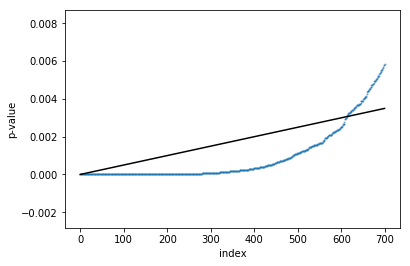

In [17]:
fig, ax = plt.subplots()

ax.scatter(indices[:700], sorted_pvals[:700], s=1, alpha=0.5)
ax.plot(indices[:700], indices[:700] * q / n_sims, c="k")

ax.set_xlabel("index")
ax.set_ylabel("p-value");

#### Values for BY<sub>$q$</sub> intervals

In [18]:
alpha_r = 1 - R * q / n_sims
z_alpha_r = np.abs(stats.norm.ppf(alpha_r))

#### Other values for plot

In [19]:
zmin = z.min()
zmax = z[9000:].max()

In [20]:
null_rejected = (z <= zmax_rej) & (indices < 9000)
nonnull_rejected = (z <= zmax_rej) & (indices >= 9000)
nonnull_nonrejected = (z > zmax_rej) & (indices >= 9000)

### Figure 20.3

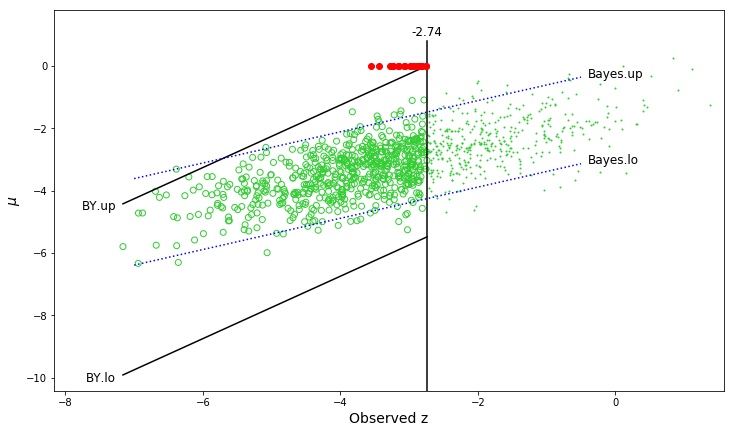

In [21]:
fig, ax = plt.subplots(figsize=(12, 7))

# null rejected z values
ax.scatter(z[nonnull_rejected], mu[nonnull_rejected], edgecolor="limegreen", facecolor="none")
ax.scatter(z[nonnull_nonrejected], mu[nonnull_nonrejected], c="limegreen", s=1)

# non-null rejected z values
ax.scatter(z[null_rejected], mu[null_rejected], c="red", zorder=10)

# BYq intervals and labels
ax.plot([zmin, zmax_rej], [zmin + z_alpha_r, zmax_rej + z_alpha_r], c="k")
ax.plot([zmin, zmax_rej], [zmin - z_alpha_r, zmax_rej - z_alpha_r], c="k")
ax.text(zmin - 0.1, zmin + z_alpha_r - 0.2, "BY.up", horizontalalignment="right", fontsize=12)
ax.text(zmin - 0.1, zmin - z_alpha_r - 0.2, "BY.lo", horizontalalignment="right", fontsize=12)

ymin, ymax = ax.get_ylim()

# vertical line for z-value at R
ax.plot([zmax_rej, zmax_rej], [ymin, ymax], c="k")
ax.text(zmax_rej, ymax + 0.1, "{:.2f}".format(zmax_rej), horizontalalignment="center", verticalalignment="bottom", fontsize=12)

# Bayes intervals and labels
ax.plot([-7, -0.5], [-10 / 2 + 1.96 / np.sqrt(2), -3.5 / 2 + 1.96 / np.sqrt(2)], c="b", linestyle=":")
ax.plot([-7, -0.5], [-10 / 2 - 1.96 / np.sqrt(2), -3.5 / 2 - 1.96 / np.sqrt(2)], c="b", linestyle=":")
ax.text(-0.4, -3.5 / 2 + 1.96 / np.sqrt(2), "Bayes.up", horizontalalignment="left", fontsize=12)
ax.text(-0.4, -3.5 / 2 - 1.96 / np.sqrt(2), "Bayes.lo", horizontalalignment="left", fontsize=12)

# misc. settings
ax.set_xlim(zmin - 1, zmax + 0.2)
ax.set_ylim(ymin, ymax + 1)

ax.set_xlabel("Observed z", size=14)
ax.set_ylabel("$\\mu$", size=14);

In [22]:
n_null_rej = null_rejected.sum()

print(
    "# of nulls rejected: {}, false discovery proportion: {:.3f}"
    "".format(n_null_rej, n_null_rej / R)
)

# of nulls rejected: 25, false discovery proportion: 0.041


In [23]:
nonnull_outside = ((mu[9000:] > z[9000:] + z_alpha_r) | (mu[9000:] < z[9000:] - z_alpha_r)).sum()
null_outside = null_rejected.sum()
total_outside = null_outside + nonnull_outside

print(
    "# nulls outside: {}, # non-nulls_outside: {}, FCR: {:.3f}"
    "".format(null_outside, nonnull_outside, total_outside / R)
)

# nulls outside: 25, # non-nulls_outside: 7, FCR: 0.052
